## This block is used for initial setup

In [1]:
import os
import math
import tqdm
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import cufflinks as cf
import tensorflow as tf
import plotly.express as px
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

init_notebook_mode(connected=True)
cf.go_offline()


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

MODELS_DIR = "C:/Users/qxem1/Computational_Intelligence/Stock Analisis/Models"

def next_free_model_name(base_name: str) -> str:
    model_files = [name for name in os.listdir(MODELS_DIR) if name.split(".")[-1].lower() == "h5"]
    similar_models_numbers = [int(name.split("_")[-1].split(".")[0]) for name in model_files if name.find(base_name) >= 0]
    
    if len(similar_models_numbers) > 0:
        max_value = str(max(similar_models_numbers)+1).zfill(3)
        new_name = base_name + "_" + max_value
    else:
        new_name = base_name + "_000"
    return new_name

def standarize_stock_price_change(data: pd.DataFrame):
    price_array = data.to_numpy()
    percentage_array = np.zeros(price_array.shape, dtype=float)
    for index, row in enumerate(price_array[1:,]):
        percentage_array[index+1] = row / price_array[index] - 1
    try:
        standarized_data = pd.DataFrame(percentage_array, columns=data.columns)
    except AttributeError:
        standarized_data = pd.DataFrame(percentage_array)
    return standarized_data


def infinite_iterator(data: list or tuple or str) -> list or tuple or char or str:
    while True:
        for item in data:
            yield item
            
    
def generate_input_sequences(data: pd.DataFrame, input_length=30, output_length=1) -> np.ndarray:
    price_array = data.to_numpy()
    input_sequences = np.zeros((price_array.shape[0] - input_length - output_length,
                                input_length, price_array.shape[1]), dtype=float)
    for index in range(input_sequences.shape[0]):
        input_sequences[index] = price_array[index:index+input_length, :]
    return input_sequences


def generate_output_sequences(data: pd.DataFrame, outputs: list, input_length=30, output_length=1) -> np.ndarray:
    selected_dataframe = data[outputs]
    price_array = selected_dataframe.to_numpy()
    if output_length == 1:
        output_sequences = np.zeros((price_array.shape[0] - input_length - output_length,
                                     price_array.shape[1]), dtype=float)
        for index in range(output_sequences.shape[0]):
            output_sequences[index] = price_array[index+input_length : index+input_length+output_length, :] 
    else:
        output_sequences = np.zeros((price_array.shape[0] - input_length - output_length,
                                     output_length, price_array.shape[1]), dtype=float)
        for index in range(output_sequences.shape[0]):
            output_sequences[index] = price_array[index+input_length : index+input_length+output_length, :]
    return output_sequences

def expand_dataset(data: pd.DataFrame, tickers):
    history = yf.download(tickers=[tickers], period="max")
    data = data.append(history)
    return data


def lineplot_comparasion(input_data: np.ndarray or list or pd.DataFrame, plot_range=(),
                         indexes=(), labels=[], colors=("b", "g", "r", "c"), linewidth=1):
    
    if type(input_data) == np.ndarray:
        data = input_data
    elif type(input_data) == list:
        if len(input_data) > 1:
            rows = input_data[0].shape[0]
            data = np.zeros((rows,len(input_data)), dtype=float)
            for index, array in enumerate(input_data):
                data[:,index] = array.reshape(rows)
        else:
            data = np.transpose(np.array(input_data, ndmin=2))
    elif type(input_data) == pd.DataFrame:
        data = input_data.to_numpy(dtype=float)
        labels = input_data.columns
    
    if not plot_range:
        plot_range = (0, data.shape[0])
    
    assert len(data.shape) == 2 or 1, "Data array has to be 2 dimensional"
    X = np.arange(plot_range[1]-plot_range[0])
    fig = plt.figure()
    color_generator = infinite_iterator(colors)
    ax = fig.add_subplot()
    if indexes:
        for index in indexes:
            ax.plot(X, data[plot_range[0]:plot_range[1], index], color=next(color_generator), linewidth=linewidth)

    else:
        for index in range(data.shape[1]):
            ax.plot(X, data[plot_range[0]:plot_range[1], index], color=next(color_generator), linewidth=linewidth)
    
    
    if len(labels) > 0:
        if indexes:
            legen_labels = []
            for index in indexes:
                legen_labels.append(labels[index])
        else:
            legen_labels = labels
        plt.legend(legen_labels, fontsize="x-large")
        
    plt.show()

----
# Selected stock
To maximize amout of data obtained Microsoft Inc. historic data was used.

[*********************100%***********************]  1 of 1 completed


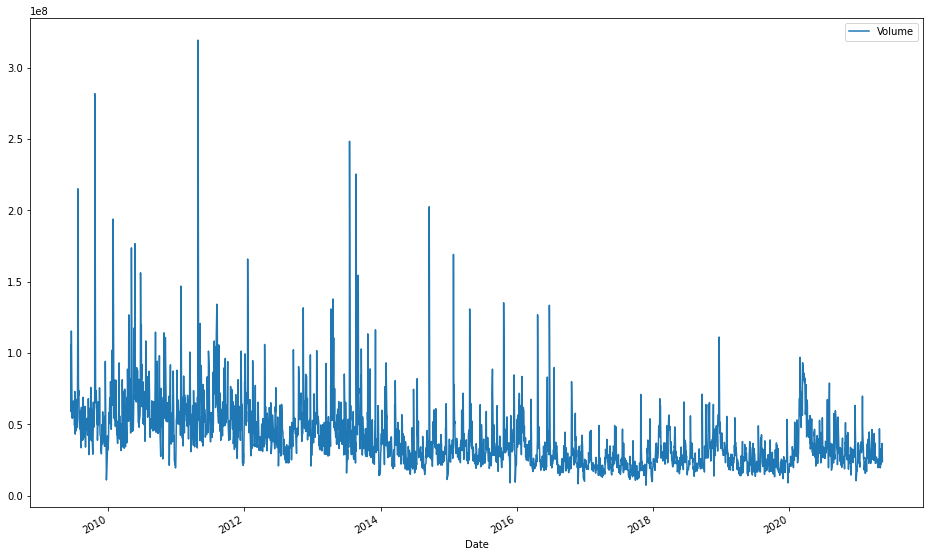

In [222]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Obtain yahoo finance data
history = yf.download(tickers=["MSFT"], period="max")
# history = expand_dataset(history, "AAPL")

# Divide data into sub-sets, stock volume is usally thousands of time higger than stock price
history_stock_prices = history[["Open", "High", "Low", "Close"]]
history_stock_amount = history[["Volume"]]

# Show part of price plot
plt.rcParams["figure.figsize"] = (16,10)
ax = history_stock_prices[["Open", "Close"]][-3000::1].plot()
fig - px.lin()

# Initial remarks
> In stated case I'll be working with sequential data.  
> In case of low accuracy obtained by regresion model model, problem may be simplified to classification.

In [232]:
from sklearn.model_selection import train_test_split
# Change of the price in percent
history_price_percentage_change = standarize_stock_price_change(history_stock_prices)
# Data sequences for input and output
sample_size = 3
predicted_values = ["Close"]

input_data = generate_input_sequences(data=history_price_percentage_change, input_length=sample_size)
output_data = generate_output_sequences(data=history_price_percentage_change, 
                                        outputs=predicted_values, input_length=sample_size)

x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1)

np.amax(history_price_percentage_change, axis=0)

Open     0.206062
High     0.167840
Low      0.197419
Close    0.195652
dtype: float64

# First model
**Huber loss** should be more resilient to outliers

In [209]:
batch_size = 50
epochs = 20

In [237]:
import keras
from keras import models
from keras import layers
from keras import metrics

model_name = "First Model"

model = models.Sequential(name=model_name)

model.add(layers.LSTM(units=50, activation="relu", return_sequences=True, name="LSTM_1",
                      input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(layers.LSTM(units=100, activation="relu", return_sequences=True, name="LSTM_2"))
model.add(layers.Dropout(0.1, name="Dropout_1"))

model.add(layers.LSTM(units=200, activation="relu", name="LSTM_3"))
model.add(layers.Dropout(0.15, name="Dropout_2"))

model.add(layers.Dense(units=200, activation="relu", name="Dense_1"))

model.add(layers.Dense(units=400, activation="relu", name="Dense_2"))
model.add(layers.Dropout(0.25, name="Dropout_3"))

model.add(layers.Dense(units=50, activation="relu", name="Dense_3"))

model.add(layers.Dense(1, activation="tanh", name="classifier"))

model.compile(optimizer="Adam", 
              loss="huber_loss", 
              metrics=["mean_absolute_percentage_error", "logcosh"])
model.summary()

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    verbose=1)

model_save_name = next_free_model_name(model_name)
model_save_path = MODELS_DIR + "/" + model_save_name + ".h5"
model.save(model_save_path)

history_save_path = MODELS_DIR + "/" + model_save_name + ".csv"
history_dataframe = pd.DataFrame(history.history)
history_dataframe.to_csv(history_save_path)

Model: "First Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 3, 50)             11000     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 3, 100)            60400     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 3, 100)            0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 200)               240800    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
Dense_2 (Dense)              (None, 400)               

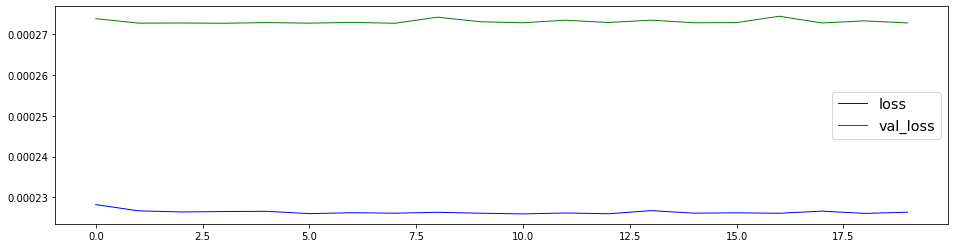

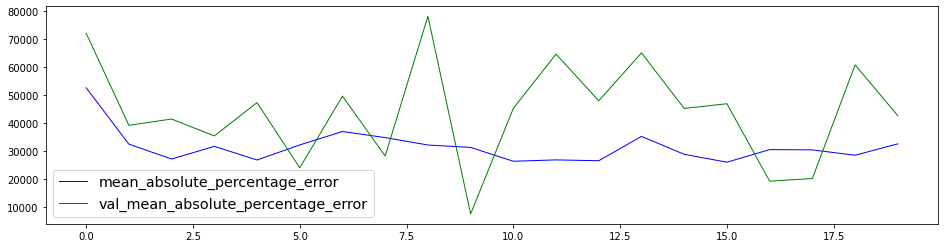

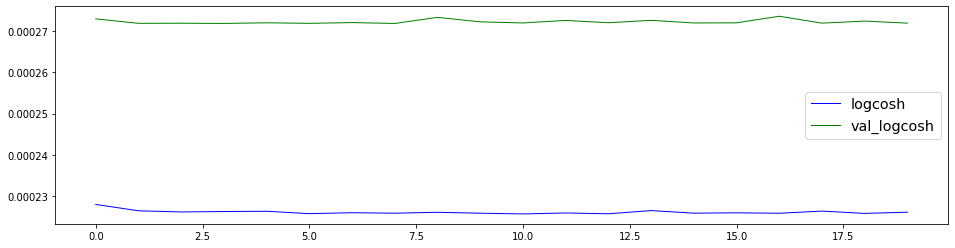

In [239]:
plt.rcParams["figure.figsize"] = (16,4)
lineplot_comparasion(history_dataframe[["loss", "val_loss"]], linewidth=1)
lineplot_comparasion(history_dataframe[["mean_absolute_percentage_error", "val_mean_absolute_percentage_error"]], linewidth=1)
lineplot_comparasion(history_dataframe[["logcosh", "val_logcosh"]], linewidth=1)

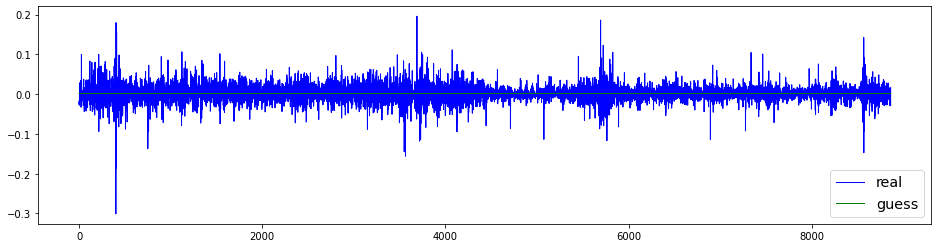

In [244]:
predictions = model.predict(input_data, batch_size=50)
lineplot_comparasion([output_data, predictions], plot_range=(), labels=["real", "guess"])

This kind of scaling produced extremely low prediction accuracy, which may be caused by many outlying values.
Addiational stock measuring parameters will be calculated and included in data (volatility, 
Beacuse of extremely low fitness, problem will be simpified to classification, initialy binay one, considered cases:
1. **Price** will go **up**
2. **Price** will go **down**

model_save_name = next_free_model_name(model_name)
history_save_path = MODELS_DIR + "/" + model_save_name + ".csv"
history_save_path = 
history_dataframe = pd.DataFrame(history.history)
history_dataframe.to_csv(history_save_path)

model1 = keras.models.load_model(save_path)
model1.summary()